In [1]:
import sys
import numpy as np
sys.path.insert(0, '/home/david/Institut/rydanalysis/')
from rydanalysis import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import interpolate
mpl.rc('image', cmap='afmhot')
sns.set_style("whitegrid")
from lmfit import Model,Parameters

In [2]:
from scipy import ndimage

In [3]:
seq = ExpSequence("/home/david/Institut/2019_IEI_new/July/19/Linescan_lowOMEGA_lowDENSITY")
#shot = SingleShot("/home/david/Institut/2019_IEI/July/02/scanblueresonance_FINAL_averaged_images/2019-06-05_00.fts")

In [4]:
variables= seq.variables.copy()
for i,shot in enumerate(seq.iter_single_shots()):
    image=shot.image
    absorb = calc_absorbtion_image(image)
    absorb = crop_image(absorb,xslice=slice(10,90),yslice=slice(10,380))
    od = absorbtion_to_OD(absorb)
    shot.optical_density = od

/home/david/Institut/rydanalysis/rydanalysis/single_shot/image_processing.py:20: RuntimeWarning: divide by zero encountered in true_divide
  trans = atoms/light
/home/david/Institut/rydanalysis/rydanalysis/single_shot/image_processing.py:20: RuntimeWarning: invalid value encountered in true_divide
  trans = atoms/light
/home/david/Institut/rydanalysis/rydanalysis/single_shot/image_processing.py:22: RuntimeWarning: invalid value encountered in greater_equal
  np.place(trans,trans>=1,1)


In [5]:
#od = ndimage.gaussian_filter(od, 4, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)

def fit2dGaussian(image):
    image = ndimage.gaussian_filter(image, 8, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)
    fit = Fit2dGaussian(image)
    #fit.params = fit.guess(image)
    #fit.params = restrict_to_init(fit.params,dev=0.2)
    #fit.params['amp'].max = fit.params['amp'].value*(1+0.5)
    #fit.params['amp'].min = fit.params['amp'].value*(1-0.5)
    #fit.params['cen_x'].max = fit.params['amp'].value*(1+0.1)
    #fit.params['cen_x'].min = fit.params['amp'].value*(1-0.1)
    #fit.params['cen_y'].max = fit.params['amp'].value*(1+0.1)
    #fit.params['cen_y'].min = fit.params['amp'].value*(1-0.1)
    #fit.params['offset'].max = fit.params['amp'].value*(1+2)
    
    fit.params['offset'].vary = False
    fit.params['offset'].value = 0

    fit.fit_data()
    return fittoSeries(fit)

In [55]:
def fit22dGaussian(image):
    #image = ndimage.gaussian_filter(image, 8, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)
    fit = Fit2d2Gaussian(image)
    #fit.params = fit.guess(image)
    # cloud distribution
    params = fit.params
    params.add('amp1',value=0.0)
    params.add('cen_y1',value=160,min=140,max=180)
    params.add('cen_x1',value=45,min=30,max=60)
    params.add('sig_x1',value=5,min=30,max=200)
    params.add('sig_y1',value=5,min=30,max=200)
    params.add('theta1',value=0,min=0,max=np.pi)

    # EIT/Autler-Townes-dip
    params.add('amp2',value=0.00)
    params.add('cen_y2',value=171.2,min=155,max=175)
    params.add('cen_x2',value=48.1,min=48,max=57)
    params.add('sig_x2',value=4.5,min=3,max=15)
    params.add('sig_y2',expr='sig_x2')
    params.add('theta2',value=0,min=0,max=np.pi)

    # offset
    params.add('offset',value=0,vary=False)
    fit.params = params
    fit.fit_data()
    return fit


In [7]:
def Series2Parameter(s):
    p = Parameters()
    keys = ['value','min','max','vary']
    for l in s.groupby(level=0):
        print(l[1])
        i = l[1:]
        name = i[0]
        kwargs = {k: i[1][name][k] for k in keys}
        p.add(name, **kwargs)
    return p

In [8]:
def stderr_weighted_average(g):
    rel_err = g.amp.stderr/g.amp.value
    weights = 1/rel_err
    return (g.image_od * weights).sum()/weights.sum()

In [58]:
def ThreeOverTwo(Dint,g31,Wc,Wp,redlw):
    """
    Imaginary Part of the first order susceptibility
    in the ladder scheme:
    index 1 ~ ground state
    index 2 ~ Rydberg state
    index 3 ~ intermediate state
    prefactor in units of MHz*m^3
    density is in units of 10^15 1/m^3
    detunings,rabi-frequencys and Decay rates in MHz
    """  
    """
    prefactor in units of MHz*m^3
    density is in units of 10^15 1/m^3
    detunings,rabi-frequencys and Decay rates in MHz
    """ 
    l=4 * redlw * Dint**2 *(g31*redlw+2*Wp)
    l1=(Wp**2+Wc**2)*(g31*Wc**2+redlw*Wp**2)
    return l/(l+l1)


In [9]:
data = seq.variables.copy()

In [10]:
data['image_od'] = [shot.optical_density[0] for shot in seq.iter_single_shots()]

In [11]:
data['image_light'] = [shot.image[3] for shot in seq.iter_single_shots()]
data['image_atoms'] = [shot.image[1] for shot in seq.iter_single_shots()]
data['image_bg'] = [shot.image[5] for shot in seq.iter_single_shots()]

data['light'] = data.image_light-data.image_bg
data['atoms'] = data.image_atoms-data.image_bg
data['diff'] = data.light- data.atoms

In [46]:
fit_res = data['image_od'].apply(fit2dGaussian)
fit_res.to_csv('fit_res.csv')
fit_res[data.columns] = data
data = fit_res

In [13]:
data['counts'] = data['light'].apply(lambda x: x[:,:].mean())

In [14]:
data.counts.std()

0.1655598364328097

In [15]:
seq.parameters.tof

0.799999999999988

In [16]:
data.counts.mean()

28.526917432598037

In [22]:
data1 = data[data.amp.value<0.5]

In [25]:
data.amp.value.std()/data.amp.value.mean()

0.1916337922969627

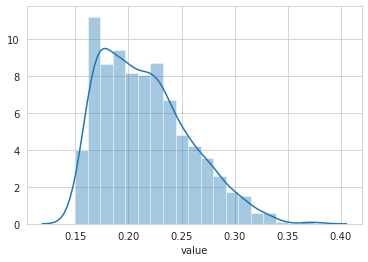

In [24]:
sns.distplot(data.amp.value)

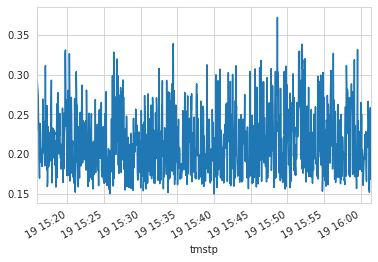

In [26]:
data.amp.value.plot()

Apply conditional filters to data set

fig,ax=plt.subplots(nrows=4,ncols=4,figsize=(20,20))
for i,group in enumerate(data.groupby('MWduration')):
    sns.distplot(group[1].counts,bins=12,ax=ax.flatten()[i])

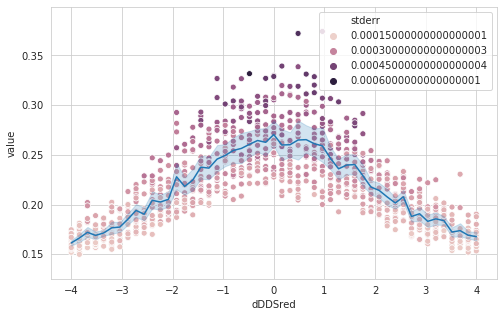

In [31]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=data.dDDSred,y=data.amp.value,hue = data.amp.stderr,markers='O')#,hue_norm=(0,0.0010))
sns.lineplot(x=data.dDDSred,y=data.amp.value)

fig,ax=plt.subplots(nrows=4,ncols=4,figsize=(20,20))
for i,group in enumerate(data.groupby('MWduration')):
    sns.distplot(group[1].amp.value,bins=7,ax=ax.flatten()[i])

fig,ax=plt.subplots(nrows=4,ncols=4,figsize=(20,20))
for i,group in enumerate(data.groupby('MWduration')):
    sns.distplot(group[1].cen_y.value,bins=7,ax=ax.flatten()[i])

### Group by *MWduration*

In [56]:
mw_av = data.groupby('dDDSred')['image_od'].apply(np.mean)

fit = mw_av.apply(fit22dGaussian)
fit_res = fit.apply(fittoSeries)

In [57]:
model32 = Model(ThreeTwoTrans,independent_vars=['Dp'])
params32 = modelL.make_params()
params32.add('g31',value=6.02,min=4,max=8,vary=False)
params32.add('Dp0',value=0,min=-1,max=1,vary=False)
params32.add('g21',value=0.1,min=0,max=2,vary=False)
params32.add('Wc',value=1.5,vary=True)
params32.add('Dc',value=-0.14,min=-1,max=1,vary=False)

NameError: name 'ThreeTwoTrans' is not defined

In [ ]:
out32 = model32.fit(Twolevel,params=params32,weights=finalweights,Dp=variables)#,nan_policy='propagate')

In [49]:
fit_res.cen_y2

,value,min,max,init_value,stderr,vary
dDDSred,,,,,,
-4.00,174.999981,160,175,171.2,None,True
-3.84,175.000000,160,175,171.2,None,True
-3.68,160.000000,160,175,171.2,None,True
-3.52,160.000095,160,175,171.2,None,True
-3.36,160.000003,160,175,171.2,None,True
-3.20,160.000014,160,175,171.2,None,True
-3.04,160.000000,160,175,171.2,None,True
-2.88,160.000000,160,175,171.2,None,True
-2.72,160.000003,160,175,171.2,None,True


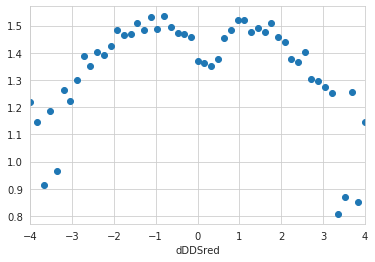

In [59]:
fit_res['3lvl_center_od'] = fit.apply(lambda x: x.eval((x.params['cen_x2'].value,x.params['cen_y2'].value)))
fit_res['2lvl_center_od'] = fit_res['3lvl_center_od']-fit_res.amp2.value
fit_res['3vs2lvl_od'] = fit_res['3lvl_center_od']/fit_res['2lvl_center_od']
fit_res['3vs2lvl_od'].plot(style='o')
#fit_res.amp1.value.plot(style='o')

In [54]:
for f in fit:
    f.fit_object
    fig,ax = plt.subplots(figsize=(20,10))
    f.plot(ax=ax,image_kwargs=dict(vmin=0.,vmax=0.6))

TypeError: 'Fit2d2Gaussian' object is not iterable

### Group density bins

In [ ]:
results = pd.DataFrame()
data1['fitted_amp_binning'] =  pd.cut(data1.amp.value,bins = np.linspace(0.2,0.7,15))
grouping = data1.groupby('fitted_amp_binning')
results['averaged_od'] = grouping.apply(stderr_weighted_average)

fit = results['averaged_od'].apply(fit22dGaussian)
fit_res = fit.apply(fittoSeries)

fit_res['3lvl_center_od'] = fit.apply(lambda x: x.eval((x.params['cen_x2'].value,x.params['cen_y2'].value)))
#fit_res['3lvl_center_od_std'] = np.sqrt(np.square(fit_res.amp2.stderr) +np.square(fit_res.amp1.stderr**2))
fit_res['2lvl_center_od'] = fit_res['3lvl_center_od']-fit_res.amp2.value
#fit_res['2lvl_center_od_std'] = fit_res.amp1.stderr
fit_res['3vs2lvl_od'] = fit_res['3lvl_center_od']/fit_res['2lvl_center_od']

In [ ]:
def three_vs_two_lvl(n,r0,n0):
    fbl = n0*n**(4./5)
    return (r0 + fbl)/(1+fbl)
model = Model(three_vs_two_lvl)
params = model.make_params()
params['r0'].value = 0.66
params['n0'].value = 1

In [ ]:
out = model.fit(fit_res['3vs2lvl_od'].values,n=fit_res['2lvl_center_od'],params=params,nan_policy='omit')

In [ ]:
fit_res.plot(y="3vs2lvl_od",x="2lvl_center_od",style='o-')
x=np.arange(0.2,0.8,0.01)

In [ ]:
for f in fit:
    fig,ax = plt.subplots(figsize=(20,10))
    f.plot(ax=ax,image_kwargs=dict(vmin=0,vmax=1.5))

In [ ]:
for fit in results.fit:
    fit.fit_object
    fig,ax = plt.subplots(figsize=(20,10))
    fit.plot(ax=ax,image_kwargs=dict(vmin=0.,vmax=0.8))

In [ ]:
results=pd.DataFrame()
results['averaged_od'] = data.groupby('MWduration')['image_od'].apply(np.mean)
results['fit']=results['averaged_od'].apply(fit22dGaussian)
#results['par'] = results['fit'].apply(lambda x: x.params)
results['center_od_ratio'] = results['fit'].apply(center_od_ratio)
results['fitted_amp1'] = results['fit'].apply(lambda x: x.params['amp1'].value)
results['fitted_amp2'] = results['fit'].apply(lambda x: x.params['amp2'].value)

In [ ]:
results.center_od_ratio.plot(style='o')
#results.fitted_amp2.plot(style = 'o')

In [ ]:
results.plot(y='center_od_ratio',x='fitted_amp1',style='o')

In [ ]:
for fit in results.fit:
    fit.fit_object
    fig,ax = plt.subplots(figsize=(20,10))
    fit.plot(ax=ax,image_kwargs=dict(vmin=0.,vmax=0.8))